In [36]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import datetime

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Или что делать, чтоб улучшить результат:

### Обработать оставшиеся признаки в понятный для машины формат
### Посмотреть, что еще можно извлечь из признаков
### Сгенерировать новые признаки
### Подгрузить дополнительные данные, например: по населению или благосостоянию городов
### Подобрать состав признаков
### В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!

## Загрузка

In [37]:
# RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
CURRENT_DATE = pd.to_datetime('07/10/2020')

In [38]:
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [39]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [40]:
df_train['sample'] = 1 #train
df_test['sample'] = 0 #test
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

## Очистка и подготовка

In [41]:
### РАзберемся со временем
data['empty_Reviews'] = (data['Reviews']=='[[], []]').astype('float64')

# анализ тестовой базы выявил два пропуска, несмотря на то, что pandas.profiling на тренировочной базе пропусков не выявил, заполним их '[[], []]' и закинем в empty_Reviews
data['Reviews'] = data['Reviews'].fillna('[[], []]')
data['empty_Reviews'] = (data['Reviews']=='[[], []]').astype('float64')

In [42]:
data['date_of_Review'] = data['Reviews'].str.findall('\d+/\d+/\d+')
## finding review dates

In [43]:
data['len_date'] = data['date_of_Review'].apply(lambda x: len(x)) ## length from date

In [44]:
data['len_date'].date_of_Review = data[data['len_date']==3].date_of_Review.apply(lambda x: x.pop(0))

In [45]:
data['one_Review'] = (data['len_date']==1).astype('float64') ## restaurants with only one review

In [46]:
def time_to_now(row):
    if row['date_of_Review'] == []:
        return None
    return datetime.datetime.now() - pd.to_datetime(row['date_of_Review']).max()

def time_between_Reviews(row):
    if row['date_of_Review'] == []:
        return None
    return pd.to_datetime(row['date_of_Review']).max() - pd.to_datetime(row['date_of_Review']).min()

data['day_to_now'] = data.apply(time_to_now, axis = 1).dt.days
data['day_between_Reviews'] = data[data['len_date']==2].apply(time_between_Reviews, axis = 1).dt.days

In [47]:
## Заполняем пропуски
data['Number of Reviews'].fillna(0, inplace=True)

### Разбираемся с городами

In [48]:
# функция для
# задания количества жителей в зависимости от города
# данные взяты из википедии
def City_population(x):
    if x == 'Paris':
        x = int(2148327)
    elif x == 'Helsinki':
        x = int(655281)
    elif x == 'Edinburgh':
        x = int(488100)
    elif x == 'London':
        x = int(8908081)
    elif x == 'Bratislava':
        x = int(437725)
    elif x == 'Lisbon':
        x = int(505526)
    elif x == 'Budapest':
        x = int(1752286)
    elif x == 'Stockholm':
        x = int(961609)
    elif x == 'Rome':
        x = int(2870500)
    elif x == 'Milan':
        x = int(1378689)
    elif x == 'Munich':
        x = int(1471508)
    elif x == 'Hamburg':
        x = int(1841179)
    elif x == 'Prague':
        x = int(1301132)
    elif x == 'Vienna':
        x = int(1897491)
    elif x == 'Dublin':
        x = int(1173179)
    elif x == 'Barcelona':
        x = int(1636762)    
    elif x == 'Brussels':
        x = int(179277)
    elif x == 'Madrid':
        x = int(3266126)    
    elif x == 'Oslo':
        x = int(673469)
    elif x == 'Amsterdam':
        x = int(872757)    
    elif x == 'Berlin':
        x = int(3644826)
    elif x == 'Lyon':
        x = int(506615)
    elif x == 'Athens':
        x = int(664046)    
    elif x == 'Warsaw':
        x = int(1790658)
    elif x == 'Oporto':
        x = int(237591)    
    elif x == 'Krakow':
        x = int(779115)
    elif x == 'Copenhagen':
        x = int(615993)    
    elif x == 'Luxembourg':
        x = int(602005)
    elif x == 'Zurich':
        x = int(428737)
    elif x == 'Geneva':
        x = int(200548)
    elif x == 'Ljubljana':
        x = int(284355)
    return x

In [49]:
#запишем данные в новый столбец
data['population'] = data['City'].apply(City_population)

In [50]:
##создадим даммис для городов
data = pd.get_dummies(data, columns=[ 'City',], dummy_na=True)

In [51]:
## make price range numerical
data['Price Range'].unique()
def dollar_to_number(x):
    if x == '$':
        return 1
    if x == '$$-$$$':
        return 2
    if x == '$$$$':
        return 3
    else:
        return 1
data['Price Range'] = data['Price Range'].apply(dollar_to_number)

In [52]:
data.sample(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
28881,id_12144,['Pizza'],12154.0,1,4.0,"[['kids love it', 'Horrible costumer service']...",/Restaurant_Review-g186338-d5123010-Reviews-Do...,d5123010,1,4.0,...,0,0,0,0,0,0,0,0,0,0
17105,id_5748,"['Italian', 'American', 'Pizza', 'Vegetarian F...",5757.0,1,346.0,"[['Evening Meal', 'Brekkie'], ['12/22/2017', '...",/Restaurant_Review-g186338-d5244240-Reviews-Fr...,d5244240,1,3.5,...,0,0,0,0,0,0,0,0,0,0
43815,id_5501,NaN,5503.0,1,19.0,"[['Best coffee in the world', 'Great value caf...",/Restaurant_Review-g187791-d7345568-Reviews-Ci...,d7345568,1,4.0,...,0,0,0,0,1,0,0,0,0,0
44859,id_687,"['Indian', 'Fast Food', 'Vegetarian Friendly',...",688.0,1,147.0,"[['Good chicken biryani', 'Taste of India in P...",/Restaurant_Review-g274707-d5501488-Reviews-Bo...,d5501488,1,4.0,...,0,0,0,1,0,0,0,0,0,0
11594,id_916,NaN,917.0,1,37.0,"[['Beer and food', 'Hidden gem of a place'], [...",/Restaurant_Review-g190454-d5986456-Reviews-Me...,d5986456,1,4.5,...,0,0,0,0,0,0,1,0,0,0


## REVIEWS

In [53]:
data.sample

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

In [54]:
data['Cuisine Style'] = data['Cuisine Style'].fillna(value="['European']") #самая популярная невегетарианская кухня

# выполним очистку от лишних символов
data['Cuisine Style'] = data['Cuisine Style'].apply(lambda x: x.replace('[', ''))
data['Cuisine Style'] = data['Cuisine Style'].apply(lambda x: x.replace(']', ''))

# подсчитаем кол-во кухонь в каждом ресторане 
# и запишем эту информацию в столбец 'Cuisine_quantity'
data['Cuisine_quantity'] = 0
n = 0
for i in data['Cuisine Style']:
    m = 0
    for j in i.split(', '):
        m += 1
    data['Cuisine_quantity'][n] = m
    n += 1

/Users/antonvice/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [20]:
##добавим столбец с показателем наличия отзывов
data['Reviews_quantity'] = data['Reviews'].apply(lambda x: 0 if (x=='[[], []]') else 1)

## Обработать оставшиеся признаки в понятный для машины формат

In [22]:
data.sample(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan,Cuisine_quantity,Reviews_quantity
33023,id_489,'Cafe',490.0,1,9.0,"[['Boutique cafe bar', 'Good'], ['08/05/2017',...",/Restaurant_Review-g274772-d12454480-Reviews-S...,d12454480,1,5.0,...,0,0,0,0,0,0,0,0,1,1
24628,id_6116,'Fast Food',6117.0,1,22.0,"[['Tasty', 'Better than KFC!'], ['07/12/2017',...",/Restaurant_Review-g187497-d10691755-Reviews-P...,d10691755,1,3.5,...,0,0,0,0,0,0,0,0,1,1
18646,id_372,"'Diner', 'French', 'Mediterranean', 'European'",373.0,1,260.0,"[['Great lunch in an authentic atmosphere', 'D...",/Restaurant_Review-g187147-d7810346-Reviews-U_...,d7810346,1,4.5,...,1,0,0,0,0,0,0,0,4,1
3401,id_3401,"'European', 'Scandinavian', 'Vegetarian Friend...",243.0,3,91.0,"[['Business seminar buffett was great', 'Excel...",/Restaurant_Review-g189934-d889593-Reviews-Mer...,d889593,0,0.0,...,0,0,0,0,0,0,0,0,4,1
13129,id_1151,"'Italian', 'Pizza', 'Street Food'",1157.0,1,11.0,"[['Very nice Italian cuisine!'], ['07/04/2015']]",/Restaurant_Review-g1974645-d8057669-Reviews-F...,d8057669,1,4.0,...,0,0,0,0,0,0,0,0,3,1


In [31]:
data['Number of Reviews'].quantile([.25, .5, .75])

0.25      7.0
0.50     28.0
0.75    105.0
Name: Number of Reviews, dtype: float64

## EDA

'много ресторанов, которые не дотягивают до 2500 места'

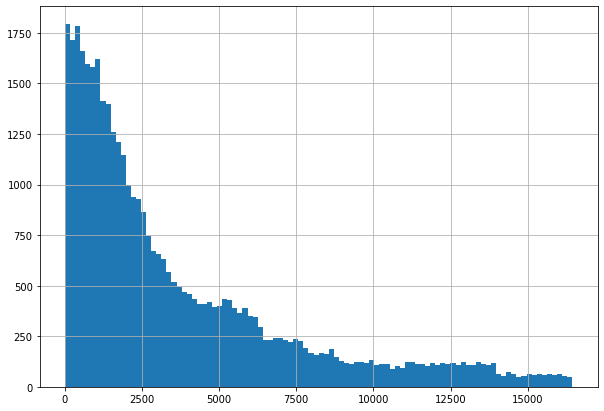

In [288]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)
'''много ресторанов, которые не дотягивают до 2500 места'''

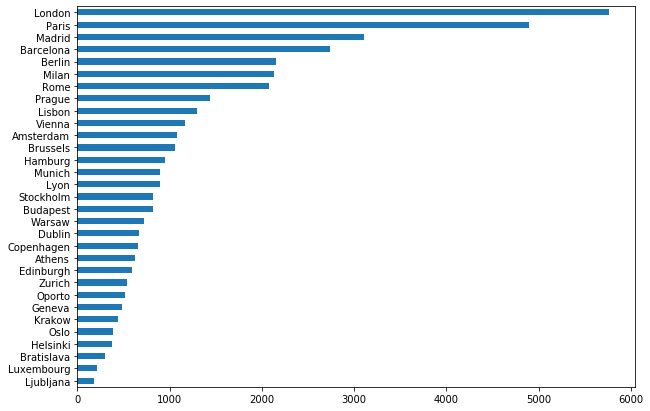

In [289]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

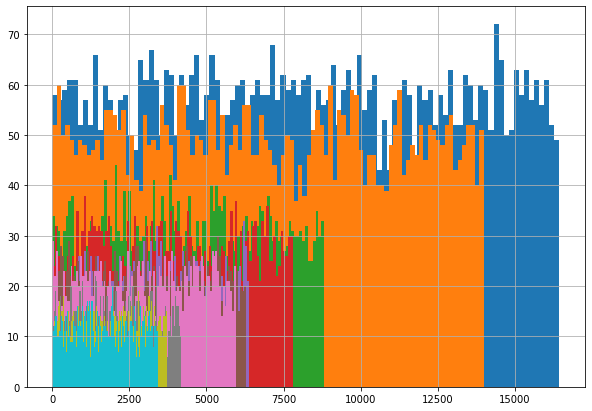

'Ranking имеет нормальное распределение,но в больших городах больше ресторанов, из-за этого и смещение.'

In [290]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()
'''Ranking имеет нормальное распределение,но в больших городах больше ресторанов, из-за этого и смещение.'''

### А теперь посмотрим на корреляцию признаков

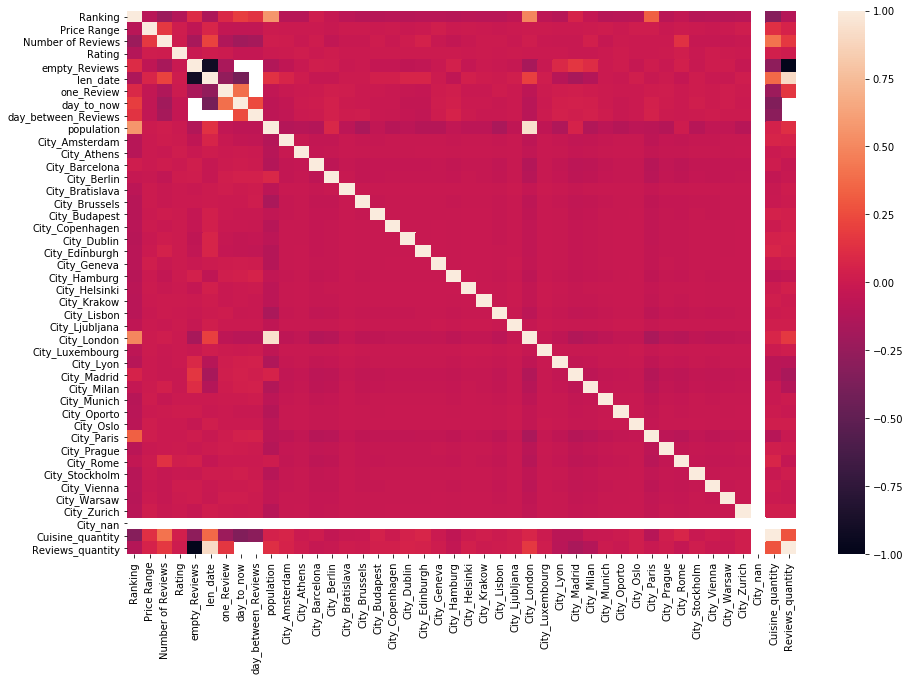

In [291]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

# Data Preprocessing

In [292]:
data

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan,Cuisine_quantity,Reviews_quantity
0,id_0,"'Bar', 'Pub'",12963.0,1,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,...,1,0,0,0,0,0,0,0,2,0
1,id_1,"'European', 'Scandinavian', 'Gluten Free Optio...",106.0,1,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,...,0,0,0,0,0,0,0,0,5,1
2,id_2,'Vegetarian Friendly',810.0,1,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,...,0,0,0,0,0,0,0,0,1,1
3,id_3,"'Italian', 'Mediterranean', 'European', 'Veget...",1669.0,3,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,...,0,0,0,0,0,0,0,0,5,1
4,id_4,"'Italian', 'Mediterranean', 'European', 'Seafo...",37.0,3,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,...,0,0,0,0,0,0,0,0,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,"'Italian', 'Vegetarian Friendly', 'Vegan Optio...",500.0,1,79.0,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414,1,4.5,...,0,0,0,0,0,0,0,0,4,1
49996,id_6340,"'French', 'American', 'Bar', 'European', 'Vege...",6341.0,1,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,1,3.5,...,1,0,0,0,0,0,0,0,5,1
49997,id_1649,"'Japanese', 'Sushi'",1652.0,1,4.0,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615,1,4.5,...,0,0,0,1,0,0,0,0,2,1
49998,id_640,"'Polish', 'European', 'Eastern European', 'Cen...",641.0,1,70.0,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838,1,4.0,...,0,0,0,0,0,1,0,0,5,1


In [293]:
# убираем категориальные признаки
data.drop(['Restaurant_id', 'City', 'Cuisine Style', 'Price Range', 'Reviews', 'URL_TA', 'ID_TA', 'date_of_Review', 'len_date', 'population'], axis=1, inplace=True, errors='ignore')

In [294]:
data

,Ranking,Number of Reviews,sample,Rating,empty_Reviews,one_Review,day_to_now,day_between_Reviews,City_Amsterdam,City_Athens,...,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan,Cuisine_quantity,Reviews_quantity
0,12963.0,4.0,0,0.0,1.0,0.0,NaN,NaN,0,0,...,1,0,0,0,0,0,0,0,2,0
1,106.0,97.0,0,0.0,0.0,0.0,1038.0,37.0,0,0,...,0,0,0,0,0,0,0,0,5,1
2,810.0,28.0,0,0.0,0.0,0.0,1015.0,22.0,0,0,...,0,0,0,0,0,0,0,0,1,1
3,1669.0,202.0,0,0.0,0.0,0.0,1037.0,14.0,0,0,...,0,0,0,0,0,0,0,0,5,1
4,37.0,162.0,0,0.0,0.0,0.0,973.0,15.0,0,0,...,0,0,0,0,0,0,0,0,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,500.0,79.0,1,4.5,0.0,0.0,1027.0,34.0,0,0,...,0,0,0,0,0,0,0,0,4,1
49996,6341.0,542.0,1,3.5,0.0,0.0,1022.0,9.0,0,0,...,1,0,0,0,0,0,0,0,5,1
49997,1652.0,4.0,1,4.5,0.0,0.0,1435.0,3127.0,0,0,...,0,0,0,1,0,0,0,0,2,1
49998,641.0,70.0,1,4.0,0.0,0.0,1185.0,23.0,0,0,...,0,0,0,0,0,1,0,0,5,1


In [295]:
## STANDARTIZATION

def StandardScaler_column(d_col):
    scaler = StandardScaler()
    scaler.fit(data[[d_col]])
    return scaler.transform(data[[d_col]])
# стандартизируем все столбцы кроме целевой и Sample
for i  in list(data.columns):
    if i not in ['Rating','sample']:
        data[i] = StandardScaler_column(i)
        if len(data[data[i].isna()]) < len(data):
            data[i] = data[i].fillna(0)

,Ranking,Number of Reviews,sample,Rating,empty_Reviews,one_Review,day_to_now,day_between_Reviews,City_Amsterdam,City_Athens,...,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan,Cuisine_quantity,Reviews_quantity
0,2.513090,-0.393140,0,0.0,2.272045,-0.357993,0.000000,0.000000,-0.167971,-0.125557,...,2.680669,-0.194136,-0.233683,-0.145244,-0.172388,-0.137291,-0.117857,0.0,-0.342827,-2.272045
1,-0.961723,-0.068159,0,0.0,-0.440132,-0.357993,-0.569984,-0.474279,-0.167971,-0.125557,...,-0.373041,-0.194136,-0.233683,-0.145244,-0.172388,-0.137291,-0.117857,0.0,1.301900,0.440132
2,-0.771455,-0.309274,0,0.0,-0.440132,-0.357993,-0.633302,-0.541676,-0.167971,-0.125557,...,-0.373041,-0.194136,-0.233683,-0.145244,-0.172388,-0.137291,-0.117857,0.0,-0.891069,0.440132
3,-0.539297,0.298756,0,0.0,-0.440132,-0.357993,-0.572737,-0.577621,-0.167971,-0.125557,...,-0.373041,-0.194136,-0.233683,-0.145244,-0.172388,-0.137291,-0.117857,0.0,1.301900,0.440132
4,-0.980371,0.158979,0,0.0,-0.440132,-0.357993,-0.748925,-0.573128,-0.167971,-0.125557,...,-0.373041,-0.194136,-0.233683,-0.145244,-0.172388,-0.137291,-0.117857,0.0,1.850143,0.440132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,-0.855238,-0.131058,1,4.5,-0.440132,-0.357993,-0.600266,-0.487758,-0.167971,-0.125557,...,-0.373041,-0.194136,-0.233683,-0.145244,-0.172388,-0.137291,-0.117857,0.0,0.753658,0.440132
49996,0.723387,1.486860,1,3.5,-0.440132,-0.357993,-0.614031,-0.600086,-0.167971,-0.125557,...,2.680669,-0.194136,-0.233683,-0.145244,-0.172388,-0.137291,-0.117857,0.0,1.301900,0.440132
49997,-0.543891,-0.393140,1,4.5,-0.440132,-0.357993,0.522934,13.409498,-0.167971,-0.125557,...,-0.373041,-0.194136,-0.233683,6.884963,-0.172388,-0.137291,-0.117857,0.0,-0.342827,0.440132
49998,-0.817130,-0.162508,1,4.0,-0.440132,-0.357993,-0.165301,-0.537183,-0.167971,-0.125557,...,-0.373041,-0.194136,-0.233683,-0.145244,-0.172388,7.283821,-0.117857,0.0,1.301900,0.440132


In [297]:
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

In [300]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [301]:
##проверка
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 41), (40000, 41), (40000, 40), (32000, 40), (8000, 40))

# Modeling

In [302]:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [303]:
model = RandomForestRegressor(n_estimators=500, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [304]:
## обучаем
model.fit(X_train, y_train)

## предсказание
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   26.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished


In [305]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20669549999999998


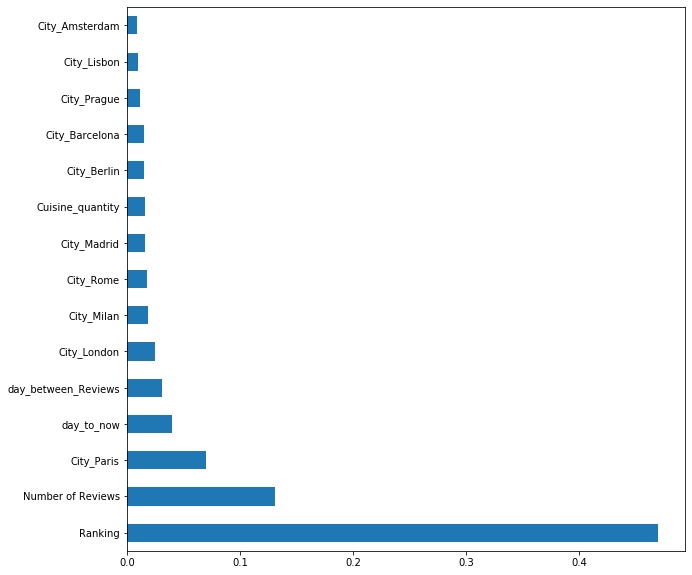

In [306]:
### посмотрим на самые важные признаки
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Testing

In [307]:
test_data = test_data.drop(['Rating'], axis=1)

In [308]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.4s finished


In [309]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.115
1,id_1,4.232
2,id_2,4.489
3,id_3,4.301
4,id_4,4.432
5,id_5,4.262
6,id_6,1.611
7,id_7,2.987
8,id_8,4.020
9,id_9,4.628


(15.5, -0.5)

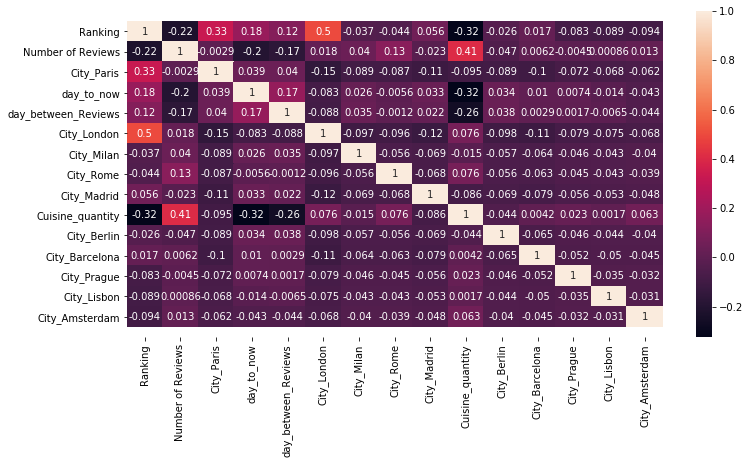

In [312]:
data_temp = data.loc[data['sample'] == 1, list(feat_importances.nlargest(15).index[0:15])]
plt.rcParams['figure.figsize'] = (12,6)
ax = sns.heatmap(data_temp.corr(), annot=True, fmt='.2g')
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5)